In [1]:
import geopandas
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import eust
import intersection
import settings
import nuts
import fadn
import plots

# Load NUTS regions GIS data

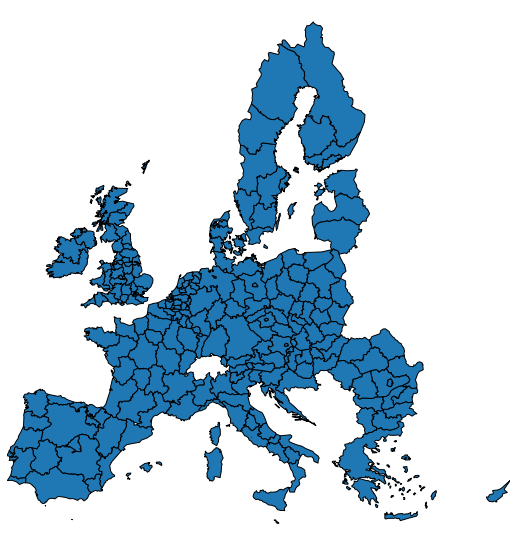

In [2]:
nuts_geo = geopandas.read_file(settings.NUTS_GIS_PATH).set_index('NUTS_ID')
included_nuts = nuts.get_included_regions()
ax = nuts_geo.loc[included_nuts].plot(edgecolor='k', legend=True).axes
plots.adj_geoplot(ax)
ax.figure.set_size_inches(10, 10)

# Load FADN regions

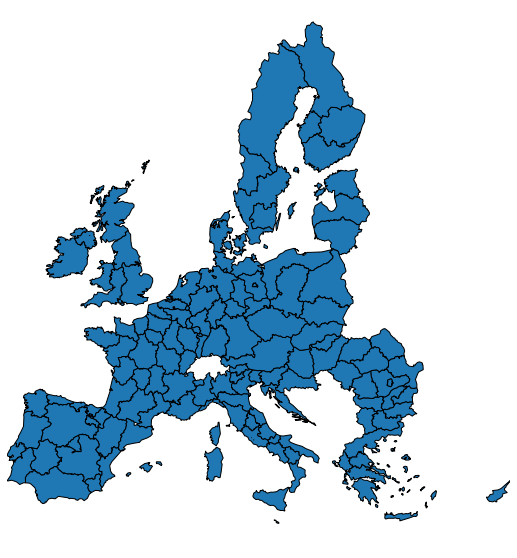

In [3]:
fadn_geo = (
    geopandas
    .read_file(settings.FADN_GIS_PATH)
    .set_index('FADN_2012_')
    [["geometry"]]
)
ax = fadn_geo.plot(edgecolor='k', legend=True).axes
plots.adj_geoplot(ax)
ax.figure.set_size_inches(10, 10)

# Load FADN data

In [4]:
fadn_data = fadn.read_fadn_data('YEAR.COUNTRY.REGION')
fadn_data

SYS02  \
year country_code country_name   region_code region_name                    
2004 BEL          Belgium        341         Vlaanderen             23150   
                                 343         Wallonie               12380   
     CYP          Cyprus         740         Cyprus                 14270   
     CZE          Czech Republic 745         Czech Republic         15930   
     DAN          Denmark        370         Denmark                33850   
...                                                                   ...   
2017 UKI          United Kingdom 412         England - East Region  21680   
                                 413         England - West Region  20700   
                                 421         Wales                  10140   
                                 431         Scotland               13140   
                                 441         Northern Ireland       14880   

                                                                           SYS03  \
year country_code country_name   region_code region_name                           
2004 BEL          Belgium        341         Vlaanderen              500 - <1000   
                                 343         Wallonie                500 - <1000   
     CYP          Cyprus         740         Cyprus                   200 - <500   
     CZE          Czech Republic 745         Czech Republic         1000 - <2000   
     DAN          Denmark        370         Denmark                1000 - <2000   
...                                                                          ...   
2017 UKI          United Kingdom 412         England - East Region   500 - <1000   
                                 413         England - West Region   500 - <1000   
                                 421         Wales                    200 - <500   
                                 431         Scotland                 200 - <500   
                                 441         Northern Ireland         200 - <500   

                                                                       SYS04  \
year country_code country_name   region_code region_name                       
2004 BEL          Belgium        341         Vlaanderen             40.33990   
                                 343         Wallonie               40.33990   
     CYP          Cyprus         740         Cyprus                  0.58192   
     CZE          Czech Republic 745         Czech Republic         31.90567   
     DAN          Denmark        370         Denmark                 7.43990   
...                                                                      ...   
2017 UKI          United Kingdom 412         England - East Region   0.88200   
                                 413         England - West Region   0.88200   
                                 421         Wales                   0.88200   
                                 431         Scotland                0.88200   
                                 441         Northern Ireland        0.88200   

                                                                    SE005  \
year country_code country_name   region_code region_name                    
2004 BEL          Belgium        341         Vlaanderen             206.4   
                                 343         Wallonie               155.1   
     CYP          Cyprus         740         Cyprus                  47.1   
     CZE          Czech Republic 745         Czech Republic         232.3   
     DAN          Denmark        370         Denmark                204.0   
...                                                                   ...   
2017 UKI          United Kingdom 412         England - East Region  329.2   
                                 413         England - West Region  226.7   
                                 421         Wales                  133.6   
                                 431         Scotland               171.7   
        

## Calculate and plot P fertilizer rates for whole UAA

In [10]:
# SE297 = total P2O5 use on farm [100 kg]
# SE025 = total UAA on farm [ha]
fadn_p_qty = (
    fadn_data['SE297']
    .mul(100)  # to kg P2O5
    .mul(31 * 2 / (31 * 2 + 16 * 5)) # to kg P
)
fadn_rates_all = (
    fadn_p_qty
    .div(fadn_data['SE025'])
    .rename('rate')
)
fadn_rates_all

year  country_code  country_name    region_code  region_name          
2004  BEL           Belgium         341          Vlaanderen                    NaN
                                    343          Wallonie                      NaN
      CYP           Cyprus          740          Cyprus                        NaN
      CZE           Czech Republic  745          Czech Republic                NaN
      DAN           Denmark         370          Denmark                       NaN
                                                                            ...   
2017  UKI           United Kingdom  412          England - East Region    9.762165
                                    413          England - West Region    5.664991
                                    421          Wales                    4.819064
                                    431          Scotland                 5.487220
                                    441          Northern Ireland         3.097915
Name: rate, Leng

In [11]:
# Check which years have P rates at all
fadn_rates_all.dropna().index.unique('year')

Int64Index([2014, 2015, 2016, 2017], dtype='int64', name='year')

In [86]:
RATE_PLOT_V_KWS = dict(vmin=0, vmax=30)
def plot_p_rate(d, ax=None, legend=True):
    ax = (
        nuts_geo
        .reindex(included_nuts)
        .plot(color='#cccccc', ax=ax)
        .axes
    )
    d.plot(
        'rate',
        cmap='Purples',
        legend=legend,
        ax=ax,
        **RATE_PLOT_V_KWS
    ).axes
    plots.adj_geoplot(ax)
    return ax

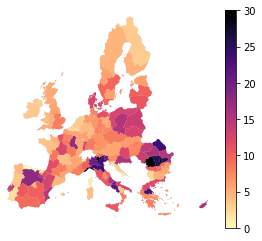

In [54]:
# Take the average value
fadn_rate = fadn_rates_all.groupby('region_code').mean().dropna()
ax = fadn_geo.join(fadn_rate).dropna().pipe(plot_p_rate)

# Load Eurostat area and P rate data

In [55]:
uaa = (
    eust
    .read_table_data('ef_lus_allcrops')
    .value
    .xs('HA', level='unit')
    .xs('UAA', level='crops')
    .xs('TOTAL', level='agrarea')
    .xs(settings.DATA_YEAR, level='time')
)
uaa

geo
AT      2726890.0
AT11     181970.0
AT12     908850.0
AT13       8020.0
AT21     220340.0
          ...    
UKM2    1247660.0
UKM3     798340.0
UKM5     478770.0
UKM6    2763560.0
UKN0    1046140.0
Name: value, Length: 330, dtype: float64

## Extract all national and subnational P application data

In [56]:
eurostat_p_qty_all = (
    eust
    .read_table_data('aei_fm_usefert')
    .value
    .xs('P', level='nutrient')
    .xs('T', level='unit')
    .mul(1e3) # to kg
)
eurostat_p_qty_all

geo  time
AL   2000    35018000.0
     2001    34586000.0
     2002    36887000.0
     2003    35127000.0
     2004    36907000.0
                ...    
UK   2014    88228000.0
     2015    85555000.0
     2016    85989000.0
     2017    86425000.0
     2018           NaN
Name: value, Length: 3857, dtype: float64

## Note that the coverage of subnational data is maximal in the chosen data year

So we do not lose anything by extracting data only from the chosen data year.

In [57]:
data_for_chosen_year = (
    eurostat_p_qty_all
    .xs(settings.DATA_YEAR, level='time')
    .reindex(included_nuts)
    .dropna()
)

mean_value_all_years = (
    eurostat_p_qty_all
    .groupby('geo')
    .mean()
    .reindex(included_nuts)
    .dropna()
)

set(data_for_chosen_year.index) == set(mean_value_all_years.index)

True

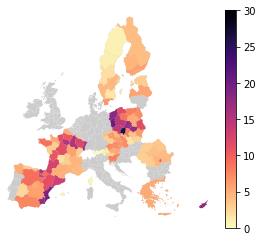

In [69]:
eurostat_p_qty = eurostat_p_qty_all.xs(settings.DATA_YEAR, level='time')
eurostat_rate = (
    eurostat_p_qty
    .div(uaa) # kg / ha
    .dropna()
    .rename('rate')
)

nuts_geo.join(eurostat_rate.reindex(included_nuts)).dropna().pipe(plot_p_rate)

# Calculate share of each FADN region in each NUTS region

In [70]:
fadn_shares = intersection.get_share(fadn_geo, nuts_geo)
fadn_shares

FADN_2012_  NUTS_ID
10          DE         0.042309
            DE6        0.005763
            DE60       0.005763
            DE600      0.005763
            DE8        0.001042
                         ...   
862         SI031      0.000940
            SI032      0.001526
            SI034      0.003705
            SI036      0.046162
            SI037      0.000202
Name: share, Length: 4363, dtype: float64

In [71]:
# Sanity check: shares should add up to about 100% in each region
fadn_shares.groupby("NUTS_ID").sum().describe()

count    1789.000000
mean        0.962331
std         0.170252
min         0.000001
25%         0.996117
50%         1.000000
75%         1.000000
max         1.000000
Name: share, dtype: float64

In [72]:
# FADN zone coverage is evidently not 100% everywhere,
# but it is good in almost all the NUTS regions we use here
fadn_shares.groupby('NUTS_ID').sum()[included_nuts].describe()

count    237.000000
mean       0.989918
std        0.033005
min        0.633784
25%        0.993374
50%        0.999438
75%        1.000000
max        1.000000
Name: share, dtype: float64

In [73]:
# Let's inspect the NUTS regions with bad coverage
bad_coverage = (
    fadn_shares
    .groupby('NUTS_ID')
    .sum()
    [included_nuts]
    .sort_values()
    .loc[lambda x: x < 0.95]
)
bad_coverage

geo
NL23    0.633784
NL32    0.813619
PT20    0.827923
MT      0.854244
NL12    0.884835
PT30    0.910481
FRA2    0.925584
FRA1    0.928762
FI20    0.938058
NL34    0.942125
DK02    0.949901
Name: share, dtype: float64

## Check that the regions with bad coverage are no real problems

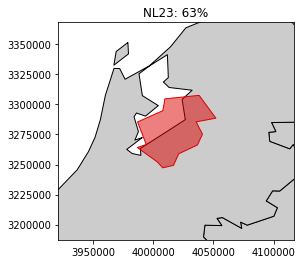

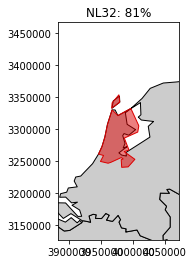

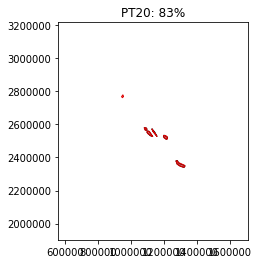

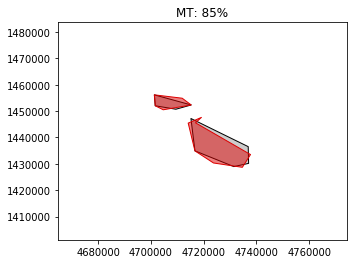

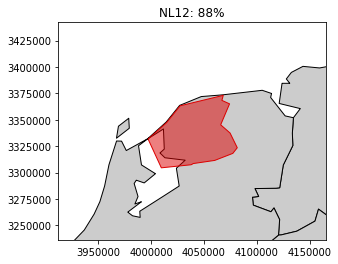

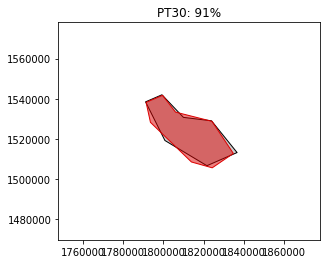

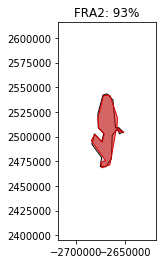

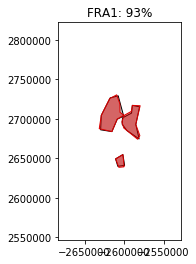

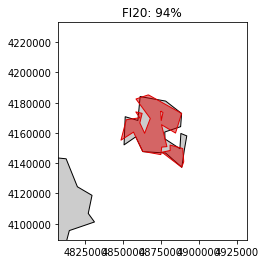

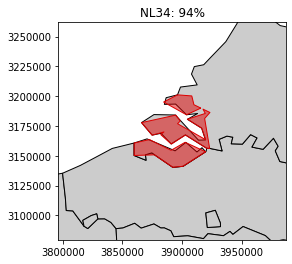

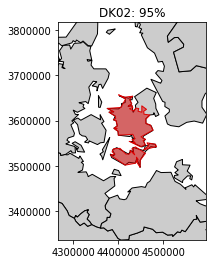

In [74]:
def plot_coverage_case(background, foreground, ax=None):
    ax = background.plot(color='#cccccc', edgecolor='k', ax=ax).axes
    foreground.plot(color='#dd000080', edgecolor='#dd0000', ax=ax)
    xmin, ymin, xmax, ymax = foreground.total_bounds
    dx = xmax - xmin
    dy = ymax - ymin
    ax.set_xlim(xmin-dx, xmax+dx)
    ax.set_ylim(ymin-dy, ymax+dy)
    return ax

for k, v in bad_coverage.items():
    ax = plot_coverage_case(fadn_geo, nuts_geo.loc[[k]])
    ax.set_title(f'{k}: {v:.0%}')

In [75]:
# To deal with the few NUTS regions that are poorly covered,
# calculate weights that by definition add up to 100% in each NUTS region.
# To avoid any mistakes, let's only include the NUTS regions used in this analysis.
fadn_weights = (
    fadn_shares
    .groupby('NUTS_ID')
    .apply(lambda s: s / s.sum())
    .loc[:, included_nuts]
)
fadn_weights.groupby('NUTS_ID').sum().describe().round(5)

count    237.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: share, dtype: float64

In [76]:
fadn_weights.to_csv("outdata/fadn-weights-by-nuts.csv", header=True)

# Calculate FADN yield in NUTS regions using weights

In [77]:
fadn_rate_nuts = (
    fadn_rate
    .rename_axis('FADN_2012_')
    .mul(fadn_weights)
    .groupby('NUTS_ID')
    .sum()
    .rename('rate')
)
fadn_rate_nuts

NUTS_ID
AT11    5.776780
AT12    5.690989
AT13    5.675897
AT21    5.685644
AT22    5.678865
          ...   
UKM2    5.436742
UKM3    5.436145
UKM5    5.436145
UKM6    5.436145
UKN0    3.013348
Name: rate, Length: 237, dtype: float64

# Calculate FADN rates adjusted to agree with national totals

In [80]:
totals = (
    fadn_rate_nuts
    .mul(uaa)
    .rename('fadn_total')
    .dropna()
    .to_frame()
    .assign(country_code=lambda s: s.index.str[:2])
    .groupby('country_code')
    .sum()
    .join(eurostat_p_qty.rename('eurostat_total'))
    .div(uaa, axis=0)
    .dropna()
)
totals

,fadn_total,eurostat_total
AT,5.692997,5.219866
BE,4.120028,3.579784
BG,6.744302,2.506160
CY,16.023772,17.790177
CZ,8.292073,5.212991
DK,12.417963,4.695839
EE,6.068237,3.267851
EL,10.692020,5.331928
ES,11.549800,8.112112
FI,4.271034,4.953868


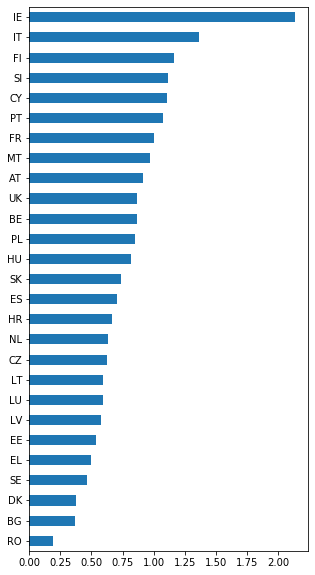

In [81]:
correction_factor = totals.eval('eurostat_total / fadn_total').rename('factor')
correction_factor.sort_values().plot.barh(figsize=(5, 10))

In [82]:
fadn_rate_nuts_adj = (
    fadn_rate_nuts
    .to_frame()
    .assign(country_code=lambda d: d.index.str[:2])
    .join(correction_factor, on='country_code', how='inner')
    .eval('rate * factor')
    .rename('rate')
)
fadn_rate_nuts_adj

NUTS_ID
AT11    5.296686
AT12    5.218024
AT13    5.204187
AT21    5.213124
AT22    5.206908
          ...   
UKM2    4.728112
UKM3    4.727592
UKM5    4.727592
UKM6    4.727592
UKN0    2.620585
Name: rate, Length: 221, dtype: float64

# Inspect the three datasets

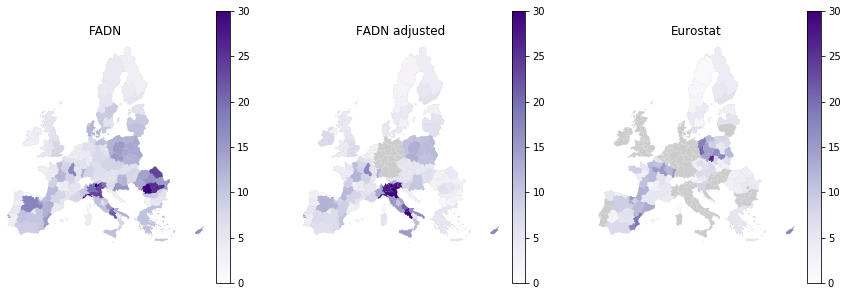

In [87]:
data = {
    'FADN': fadn_rate_nuts,
    'FADN adjusted': fadn_rate_nuts_adj,
    'Eurostat': eurostat_rate.reindex(included_nuts).dropna(),
}

fig, axs = plt.subplots(ncols=len(data), figsize=(5*len(data), 5))

for (title, s), ax in zip(data.items(), axs):
    plot_p_rate(nuts_geo.join(s, how='inner'), ax=ax)
    ax.set_title(title)

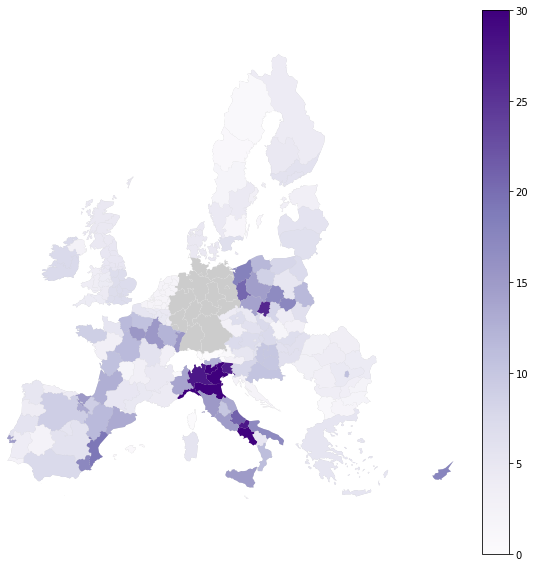

In [89]:
final_estimate = fadn_rate_nuts_adj.reindex(included_nuts)
final_estimate.update(eurostat_rate)
ax = plot_p_rate(nuts_geo.join(final_estimate).dropna())
ax.figure.set_size_inches(10, 10)

In [12]:
nuts_yield.to_csv('outdata/permanent_grassland_yield_by_nuts.csv', header=True)